In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from collections import Counter
import re
from PyKakao import Local
import warnings
warnings.filterwarnings('ignore')

In [100]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
train = train[test.columns.tolist() + ['사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO']]

accident = pd.read_csv("./data/external_open/countrywide_accident.csv")
CCTV = pd.read_csv("./data/external_open/대구CCTV정보.csv", encoding='cp949')
light = pd.read_csv("./data/external_open/대구보안등정보.csv", encoding='cp949')
child = pd.read_csv("./data/external_open/대구어린이보호구역정보.csv", encoding='cp949')
parking = pd.read_csv("./data/external_open/대구주차장정보.csv", encoding='cp949')


In [101]:
# 피하자의 정보에 Na 값이 있는 것을 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
 8   사망자수    39609 non-null  int64 
 9   중상자수    39609 non-null  int64 
 10  경상자수    39609 non-null  int64 
 11  부상자수    39609 non-null  int64 
 12  ECLO    39609 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 3.9+ MB


In [102]:
# 카메라 관리번호는 이름이므로 영향이 없을거라 판단
# 시도명은 전부 대구광역시이므로 삭제
# 시군구명은 소재지지번주소에 포함되어있으므로 삭제
# 도로노선명은 소재지지번주소로 표현이 가능하다 판단해 삭제 -> train 데이터와 결합할 때 지번주소를 사용할 예정이므로 필요가 없음
# 위도와 경도는 정확한 위치 정보이므로 소재재지번주소로 대체
# 설치장소는 소재지지번주소로 대체
CCTV = CCTV[["위도","경도","소재지지번주소", "도로노선방향", "도로종류", "단속구분", "제한속도", "단속구간위치구분", "과속단속구간길이", "보호구역구분", "설치연도"]]
CCTV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   위도        1065 non-null   float64
 1   경도        1065 non-null   float64
 2   소재지지번주소   1063 non-null   object 
 3   도로노선방향    1065 non-null   int64  
 4   도로종류      1065 non-null   object 
 5   단속구분      1065 non-null   int64  
 6   제한속도      1065 non-null   int64  
 7   단속구간위치구분  53 non-null     float64
 8   과속단속구간길이  26 non-null     float64
 9   보호구역구분    893 non-null    float64
 10  설치연도      1065 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 91.6+ KB


In [103]:
# 보안등위치명은 소재지지번주소로 대체
# 소재지도로명주소, 위도와 경도는 지번주소를 사용할 것이므로 삭제
light = light[["위도","경도", "소재지지번주소","설치개수", "설치연도", "설치형태"]]
light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71913 entries, 0 to 71912
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   위도       43602 non-null  float64
 1   경도       43602 non-null  float64
 2   소재지지번주소  71913 non-null  object 
 3   설치개수     71913 non-null  int64  
 4   설치연도     29397 non-null  float64
 5   설치형태     35373 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 3.3+ MB


In [104]:
# 대상시설명, 소재지도로명주소, 위도, 경도는 소재지지번주소로 대체
# 관리기관명과 관할경찰서명은 주소에 따라 다르고 예측에 영향을 주지 않을 것이라 판단
child = child[["위도","경도","소재지지번주소", "시설종류", "CCTV설치여부","CCTV설치대수","보호구역도로폭"]]
child.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   위도        640 non-null    float64
 1   경도        640 non-null    float64
 2   소재지지번주소   555 non-null    object 
 3   시설종류      640 non-null    object 
 4   CCTV설치여부  640 non-null    object 
 5   CCTV설치대수  465 non-null    float64
 6   보호구역도로폭   320 non-null    object 
dtypes: float64(3), object(4)
memory usage: 35.1+ KB


In [105]:
# 관리번호, 주차장명, 소재지도로명주소, 결제방법, 특기사항 삭제
parking = parking[["위도","경도", "소재지지번주소",'주차장구분', '주차장유형', '주차구획수', '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금']]
parking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   위도           697 non-null    float64
 1   경도           697 non-null    float64
 2   소재지지번주소      775 non-null    object 
 3   주차장구분        871 non-null    object 
 4   주차장유형        871 non-null    object 
 5   주차구획수        871 non-null    int64  
 6   급지구분         871 non-null    int64  
 7   부제시행구분       871 non-null    object 
 8   운영요일         871 non-null    object 
 9   평일운영시작시각     871 non-null    object 
 10  평일운영종료시각     871 non-null    object 
 11  토요일운영시작시각    871 non-null    object 
 12  토요일운영종료시각    871 non-null    object 
 13  공휴일운영시작시각    871 non-null    object 
 14  공휴일운영종료시각    871 non-null    object 
 15  요금정보         871 non-null    object 
 16  주차기본시간       871 non-null    int64  
 17  주차기본요금       871 non-null    int64  
 18  추가단위시간       298 non-null    float64
 19  추가단위요금  

# EDA

### 1. 데이터 구성 변경

In [106]:
train_new = train.copy()

# ID 삭제
train_new = train_new.drop(["ID"], axis = 1)

# Hour 변수 추가
train_new["Hour"] = [i.split()[1] for i in train_new.사고일시]
train_new["사고일시"] = [i.split()[0] for i in train_new.사고일시]

# Year, Month, Day 변수 추가
train_new["Year"] = [i.split("-")[0] for i in train_new.사고일시]
train_new["Month"] = [i.split("-")[1] for i in train_new.사고일시]
train_new["Day"] = [i.split("-")[2] for i in train_new.사고일시]
train_new["Year_Month"] = [train_new.Year[i] + train_new.Month[i] for i in range(len(train_new))]
train_new = train_new.drop(["사고일시"], axis = 1)

# 시군구 분리
train_new["군"] = [i.split(" ")[1] for i in train_new.시군구]
train_new["구"] = [i.split(" ")[2] for i in train_new.시군구]
train_new = train_new.drop(["시군구"], axis = 1)

# 도로형태 분리
train_new["도로형태대분류"] = [i.split("-")[0] for i in train_new.도로형태]
train_new["도로형태소분류"] = [i.split("-")[1] for i in train_new.도로형태]
train_new = train_new.drop(["도로형태"], axis = 1)

In [107]:
train_new

,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,Hour,Year,Month,Day,Year_Month,군,구,도로형태대분류,도로형태소분류
0,화요일,맑음,건조,차대사람,0,1,0,0,5,00,2019,01,01,201901,중구,대신동,단일로,기타
1,화요일,흐림,건조,차대사람,0,0,1,0,3,00,2019,01,01,201901,달서구,감삼동,단일로,기타
2,화요일,맑음,건조,차대사람,0,0,1,0,3,01,2019,01,01,201901,수성구,두산동,단일로,기타
3,화요일,맑음,건조,차대차,0,1,0,0,5,02,2019,01,01,201901,북구,복현동,단일로,기타
4,화요일,맑음,건조,차대차,0,0,1,0,3,04,2019,01,01,201901,동구,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,0,0,1,0,3,19,2021,12,31,202112,수성구,수성동3가,교차로,교차로안
39605,금요일,맑음,건조,차대차,0,0,1,0,3,19,2021,12,31,202112,달서구,상인동,단일로,기타
39606,금요일,맑음,건조,차대차,0,2,0,0,10,21,2021,12,31,202112,달서구,월성동,교차로,교차로안
39607,금요일,맑음,건조,차대차,0,0,1,0,3,22,2021,12,31,202112,달서구,장동,기타,기타


In [108]:
CCTV["구"] = [i.split()[2] if type(i) == str else i for i in CCTV.소재지지번주소]
LOCAL = Local(service_key = "3206f186fc6467db13a17a82c6e3e668")
for i in CCTV[CCTV.구.isna()].index:
    CCTV.구.iloc[i] = LOCAL.geo_coord2address(CCTV.iloc[i].경도, CCTV.iloc[i].위도, dataframe=True).address[0]["region_3depth_name"]
CCTV.구 = [re.sub(r"동[0-9]+-[0-9]+$|[0-9].[0-9]동$|[0-9]동$", '동', i) for i in CCTV.구]
CCTV.구 = [re.sub(r"가[0-9]+-[0-9]+$", '가', i) for i in CCTV.구]

# train 데이터의 사고가 난 시군구 노선방향, 도로종류, 단속구간위치구분, 과속단속구간길이는 
# 보호구역 여부
CCTV["어린이보호구역"] = [1 if i == 2 else 0 for i in CCTV.보호구역구분]
CCTV["노인보호구역"] = [1 if i == 1 else 0 for i in CCTV.보호구역구분]
CCTV["기타보호구역"] = [1 if i == 99 else 0 for i in CCTV.보호구역구분]

# 단속구분
CCTV["속도단속"] = [1 if i == 1 else 0 for i in CCTV.단속구분]
CCTV["신호단속"] = [1 if i == 2 else 0 for i in CCTV.단속구분]
CCTV["통행위반"] = [1 if i == 3 else 0 for i in CCTV.단속구분]
CCTV["불법주정차"] = [1 if i == 4 else 0 for i in CCTV.단속구분]
CCTV["기타단속"] = [1 if i == 99 else 0 for i in CCTV.단속구분]

CCTV = CCTV[['설치연도', '구', '어린이보호구역', '노인보호구역', '기타보호구역', '속도단속', '신호단속', '통행위반',
       '불법주정차', '기타단속']]

CCTV

,설치연도,구,어린이보호구역,노인보호구역,기타보호구역,속도단속,신호단속,통행위반,불법주정차,기타단속
0,2010.0,대명동,0,0,1,0,0,0,1,0
1,2013.0,봉덕동,0,0,1,0,0,0,1,0
2,2013.0,봉덕동,0,0,1,0,0,0,1,0
3,2014.0,대명동,0,0,1,0,0,0,1,0
4,2014.0,봉덕동,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1060,2021.0,구암동,0,0,1,0,1,0,0,0
1061,2021.0,사수동,1,0,0,0,1,0,0,0
1062,2021.0,대현동,1,0,0,0,1,0,0,0
1063,2021.0,대현동,1,0,0,0,1,0,0,0


In [109]:
# 사고 날짜는 정확한데 CCTV 설치날짜는 세세하지않고 연도만 나와있음
# train 데이터는 2019년의 경우 2018년 이전 CCTV 갯수만 반영, 2020년의 경우 2019년 이전 CCTV 갯수만 반영한다.
def df_add(row, df2):
    if row.구 in df2.구.tolist():
        row[row.index.drop(["구"])] += df2.iloc[df2.구.tolist().index(row.구)][df2.columns.drop(["구"])]
    return row

CCTV_2018_before = CCTV[CCTV.설치연도 < 2019]
CCTV_2019 = CCTV[CCTV.설치연도 == 2019]
CCTV_2020 = CCTV[CCTV.설치연도 == 2020]
CCTV_2021 = CCTV[CCTV.설치연도 == 2021]

CCTV_2018_before = CCTV_2018_before.groupby("구").sum()
CCTV_2018_before = CCTV_2018_before.reset_index()
CCTV_2018_before = CCTV_2018_before.drop(["설치연도"], axis = 1)

CCTV_2019 = CCTV_2019.groupby("구").sum()
CCTV_2019 = CCTV_2019.reset_index()
CCTV_2019 = CCTV_2019.drop(["설치연도"], axis = 1)

CCTV_2020 = CCTV_2020.groupby("구").sum()
CCTV_2020 = CCTV_2020.reset_index()
CCTV_2020 = CCTV_2020.drop(["설치연도"], axis = 1)

CCTV_2021 = CCTV_2021.groupby("구").sum()
CCTV_2021 = CCTV_2021.reset_index()
CCTV_2021 = CCTV_2021.drop(["설치연도"], axis = 1)

CCTV_2019_Total = CCTV_2018_before.copy()

CCTV_2020_Total = pd.DataFrame()
CCTV_2020_Total["구"] = list(set(CCTV_2018_before.구.tolist())|set(CCTV_2019.구.tolist()))
CCTV_2020_Total[CCTV_2019.columns.drop(["구"])] = 0
CCTV_2020_Total = CCTV_2020_Total.apply(lambda x : df_add(x, CCTV_2018_before), axis = 1)
CCTV_2020_Total = CCTV_2020_Total.apply(lambda x : df_add(x, CCTV_2019), axis = 1)

CCTV_2021_Total = pd.DataFrame()
CCTV_2021_Total["구"] = list(set(CCTV_2020_Total.구.tolist())|set(CCTV_2020.구.tolist()))
CCTV_2021_Total[CCTV_2020.columns.drop(["구"])] = 0
CCTV_2021_Total = CCTV_2021_Total.apply(lambda x : df_add(x, CCTV_2020_Total), axis = 1)
CCTV_2021_Total = CCTV_2021_Total.apply(lambda x : df_add(x, CCTV_2020), axis = 1)

CCTV_2022_Total = pd.DataFrame()
CCTV_2022_Total["구"] = list(set(CCTV_2021_Total.구.tolist())|set(CCTV_2021.구.tolist()))
CCTV_2022_Total[CCTV_2021.columns.drop(["구"])] = 0
CCTV_2022_Total = CCTV_2022_Total.apply(lambda x : df_add(x, CCTV_2021_Total), axis = 1)
CCTV_2022_Total = CCTV_2022_Total.apply(lambda x : df_add(x, CCTV_2021), axis = 1)

CCTV_2019_Total["Year"] = "2019"
CCTV_2020_Total["Year"] = "2020"
CCTV_2021_Total["Year"] = "2021"
CCTV_2022_Total["Year"] = "2022"
CCTV_Total = pd.concat([CCTV_2019_Total, CCTV_2020_Total, CCTV_2021_Total, CCTV_2022_Total])

train_new = pd.merge(train_new, CCTV_Total, how = "left", on = ["구", "Year"])
train_new = train_new.fillna(0)
train_new["총CCTV개수"] = train_new[['속도단속', '신호단속', '통행위반', '불법주정차', '기타단속']].sum(axis=1)

In [110]:
train_new

,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,Hour,...,도로형태소분류,어린이보호구역,노인보호구역,기타보호구역,속도단속,신호단속,통행위반,불법주정차,기타단속,총CCTV개수
0,화요일,맑음,건조,차대사람,0,1,0,0,5,00,...,기타,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0
1,화요일,흐림,건조,차대사람,0,0,1,0,3,00,...,기타,0.0,0.0,2.0,1.0,1.0,0.0,7.0,0.0,9.0
2,화요일,맑음,건조,차대사람,0,0,1,0,3,01,...,기타,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0
3,화요일,맑음,건조,차대차,0,1,0,0,5,02,...,기타,2.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,5.0
4,화요일,맑음,건조,차대차,0,0,1,0,3,04,...,기타,1.0,0.0,7.0,2.0,6.0,0.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,0,0,1,0,3,19,...,교차로안,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
39605,금요일,맑음,건조,차대차,0,0,1,0,3,19,...,기타,8.0,0.0,6.0,2.0,7.0,0.0,8.0,3.0,20.0
39606,금요일,맑음,건조,차대차,0,2,0,0,10,21,...,교차로안,11.0,0.0,1.0,0.0,5.0,0.0,11.0,0.0,16.0
39607,금요일,맑음,건조,차대차,0,0,1,0,3,22,...,기타,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# 보안등 설치연도가 없는 경우도 있는데 설치연도가 있는 경우 전부 2019년 이전에 지어졌다.
# 있는 경우는 2019년 이전이고 없는 경우는 설치연도를 고려하기 어려우므로 설치연도를 고려하지 않음
light[light.설치연도 >= 2020]

,위도,경도,소재지지번주소,설치개수,설치연도,설치형태


In [112]:
# 정확한 주소가 안나오는 경우가 꽤 됨 -> 위도, 경도로 확인을 해봤으나 서구 둔산동으로 나오는 것으로 보아 소재지가 정확하지 않은 것으로 보임
# -> 소재지가 정확하지 않은 정보는 삭제하고 진행하지만 보안등 변수는 사용여부를 고려해야할 것 같음
light[[len(i.split())<3 for i in light.소재지지번주소]].head()

,위도,경도,소재지지번주소,설치개수,설치연도,설치형태
25250,35.912633,128.686217,대구광역시 동구,1,NaN,전용주
25797,35.912633,128.686217,대구광역시 동구,1,NaN,한전주
25989,35.912633,128.686217,대구광역시 동구,1,NaN,한전주
26017,35.912633,128.686217,대구광역시 동구,1,NaN,전용주
26018,35.912633,128.686217,대구광역시 동구,1,NaN,한전주


In [113]:
light = light[[len(i.split())>=3 for i in light.소재지지번주소]]
light["구"] = [i.split()[2] for i in light.소재지지번주소]

light.구 = [re.sub(r"동[0-9]+-[0-9]+$|[0-9]동$|[0-9].[0-9]동$", "동", i) for i in light.구]
light.구 = [re.sub(r"[0-9]+-[0-9]+$", "", i) for i in light.구]
light.구 = [re.sub(r"[0-9]+$", "", i) for i in light.구]
light = light.iloc[[i for i in range(len(light)) if light.구.iloc[i] != ""]]
light = light.groupby("구").sum().설치개수.reset_index()
light = light.rename(columns = {"설치개수" : "보안등개수"})

train_new = pd.merge(train_new, light, how = "left", on = ["구"])

In [114]:
train_new

,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,Hour,...,어린이보호구역,노인보호구역,기타보호구역,속도단속,신호단속,통행위반,불법주정차,기타단속,총CCTV개수,보안등개수
0,화요일,맑음,건조,차대사람,0,1,0,0,5,00,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,391.0
1,화요일,흐림,건조,차대사람,0,0,1,0,3,00,...,0.0,0.0,2.0,1.0,1.0,0.0,7.0,0.0,9.0,941.0
2,화요일,맑음,건조,차대사람,0,0,1,0,3,01,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,473.0
3,화요일,맑음,건조,차대차,0,1,0,0,5,02,...,2.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,5.0,597.0
4,화요일,맑음,건조,차대차,0,0,1,0,3,04,...,1.0,0.0,7.0,2.0,6.0,0.0,0.0,0.0,8.0,2065.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,0,0,1,0,3,19,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
39605,금요일,맑음,건조,차대차,0,0,1,0,3,19,...,8.0,0.0,6.0,2.0,7.0,0.0,8.0,3.0,20.0,844.0
39606,금요일,맑음,건조,차대차,0,2,0,0,10,21,...,11.0,0.0,1.0,0.0,5.0,0.0,11.0,0.0,16.0,167.0
39607,금요일,맑음,건조,차대차,0,0,1,0,3,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0


In [115]:
# 소재지 주소 중 NA가 아닌 값 중 정확한 소재지지번주소가 나오지않은 값을 뽑아보니 띄어쓰기가 아닌 ?로 되어있다.
# ?로 띄어쓰기가 되어있는 행은 이 행 뿐이었다.
child[child.소재지지번주소.notna()][[len(i.split())<3 for i in child.소재지지번주소 if type(i) == str ]]

,위도,경도,소재지지번주소,시설종류,CCTV설치여부,CCTV설치대수,보호구역도로폭
492,35.885754,128.578864,대구광역시?서구?원대동3가 1120-1,어린이집,Y,NaN,8


In [116]:
child["구"] = [i.split() if type(i) == str else i for i in child.소재지지번주소]
child["구"] = [i[0].split("?") if type(i) == list and len(i) == 2 else i for i in child.구]
child["구"] = [i[2] if type(i) == list else False for i in child.구]

for i in child[child.구 == False].index:
    child.구.iloc[i] = LOCAL.geo_coord2address(child.iloc[i].경도, child.iloc[i].위도, dataframe=True).address[0]["region_3depth_name"]
    
child.CCTV설치여부 = [1 if i == "Y" else 0 for i in child.CCTV설치여부]

In [117]:
# CCTV 설치대수 변수는 CCTV가 설치되어있음에도 값이 존재하지 않는 경우가 많아 변수를 삭제, 보호구역도로폭도 없는 값이 많아 삭제
child[child.CCTV설치대수.isna()]

,위도,경도,소재지지번주소,시설종류,CCTV설치여부,CCTV설치대수,보호구역도로폭,구
442,35.881144,128.607228,대구광역시 북구 대현동 534,유치원,0,NaN,NaN,대현동
445,35.860880,128.552788,대구광역시 서구 내당동 296,초등학교,1,NaN,10,내당동
446,35.863819,128.566759,대구광역시 서구 내당동 11-33,초등학교,1,NaN,9,내당동
447,35.863819,128.566759,대구광역시 서구 내당동 11-33,유치원,1,NaN,9,내당동
448,35.866845,128.550517,대구광역시 서구 중리동 65-2,초등학교,1,NaN,26,중리동
...,...,...,...,...,...,...,...,...
614,35.822376,128.608849,대구광역시 수성구 파동 20-3,유치원,1,NaN,NaN,파동
615,35.839157,128.615443,대구광역시 수성구 상동 15-1,어린이집,1,NaN,NaN,상동
616,35.844295,128.699414,대구광역시 수성구 시지동 37,유치원,1,NaN,NaN,시지동
617,35.861684,128.611786,대구광역시 수성구 수성동4가 1198,어린이집,1,NaN,NaN,수성동4가


In [118]:
child = child[["CCTV설치여부","구"]]
child = child.rename(columns = {"CCTC설치여부" : "어린이보호구역CCTV여부"})
child = child.groupby("구").sum().reset_index()

train_new = pd.merge(train_new, child, how = "left", on = ["구"])
train_new = train_new.fillna(0)

In [122]:
train_new

,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,Hour,...,노인보호구역,기타보호구역,속도단속,신호단속,통행위반,불법주정차,기타단속,총CCTV개수,보안등개수,CCTV설치여부
0,화요일,맑음,건조,차대사람,0,1,0,0,5,00,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,391.0,2.0
1,화요일,흐림,건조,차대사람,0,0,1,0,3,00,...,0.0,2.0,1.0,1.0,0.0,7.0,0.0,9.0,941.0,0.0
2,화요일,맑음,건조,차대사람,0,0,1,0,3,01,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,473.0,5.0
3,화요일,맑음,건조,차대차,0,1,0,0,5,02,...,0.0,3.0,0.0,5.0,0.0,0.0,0.0,5.0,597.0,9.0
4,화요일,맑음,건조,차대차,0,0,1,0,3,04,...,0.0,7.0,2.0,6.0,0.0,0.0,0.0,8.0,2065.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,0,0,1,0,3,19,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
39605,금요일,맑음,건조,차대차,0,0,1,0,3,19,...,0.0,6.0,2.0,7.0,0.0,8.0,3.0,20.0,844.0,0.0
39606,금요일,맑음,건조,차대차,0,2,0,0,10,21,...,0.0,1.0,0.0,5.0,0.0,11.0,0.0,16.0,167.0,0.0
39607,금요일,맑음,건조,차대차,0,0,1,0,3,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.0


In [138]:
print(Counter(train_new.사망자수))
print(Counter(train_new.중상자수))
print(Counter(train_new.경상자수))
print(Counter(train_new.부상자수))


Counter({0: 39309, 1: 292, 2: 8})
Counter({0: 30136, 1: 8724, 2: 618, 3: 98, 4: 28, 5: 4, 6: 1})
Counter({1: 20913, 0: 10284, 2: 5560, 3: 1728, 4: 732, 5: 259, 6: 77, 7: 32, 9: 7, 8: 7, 10: 2, 15: 2, 14: 1, 11: 1, 12: 1, 18: 1, 13: 1, 22: 1})
Counter({0: 35168, 1: 4046, 2: 279, 3: 67, 4: 35, 5: 9, 6: 3, 7: 1, 10: 1})


In [141]:
# 아무도 안다친 사고는 없음
Counter(train_new.사망자수 + train_new.중상자수 + train_new.경상자수 + train_new.부상자수)

Counter({1: 28117,
         2: 7392,
         6: 144,
         3: 2426,
         4: 997,
         7: 52,
         5: 421,
         9: 8,
         8: 28,
         13: 3,
         15: 3,
         10: 7,
         12: 2,
         11: 4,
         18: 1,
         16: 1,
         14: 1,
         22: 2})

In [144]:
train_new[train_new.사망자수 + train_new.중상자수 + train_new.경상자수 + train_new.부상자수 == 22].T


,32591,37536
요일,금요일,월요일
기상상태,맑음,맑음
노면상태,건조,건조
사고유형,차대차,차대차
사망자수,0,0
중상자수,4,0
경상자수,18,22
부상자수,0,0
ECLO,74,66
Hour,14,09


In [162]:
train_new

,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,Hour,...,노인보호구역,기타보호구역,속도단속,신호단속,통행위반,불법주정차,기타단속,총CCTV개수,보안등개수,CCTV설치여부
0,화요일,맑음,건조,차대사람,0,1,0,0,5,00,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,391.0,2.0
1,화요일,흐림,건조,차대사람,0,0,1,0,3,00,...,0.0,2.0,1.0,1.0,0.0,7.0,0.0,9.0,941.0,0.0
2,화요일,맑음,건조,차대사람,0,0,1,0,3,01,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,473.0,5.0
3,화요일,맑음,건조,차대차,0,1,0,0,5,02,...,0.0,3.0,0.0,5.0,0.0,0.0,0.0,5.0,597.0,9.0
4,화요일,맑음,건조,차대차,0,0,1,0,3,04,...,0.0,7.0,2.0,6.0,0.0,0.0,0.0,8.0,2065.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,0,0,1,0,3,19,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
39605,금요일,맑음,건조,차대차,0,0,1,0,3,19,...,0.0,6.0,2.0,7.0,0.0,8.0,3.0,20.0,844.0,0.0
39606,금요일,맑음,건조,차대차,0,2,0,0,10,21,...,0.0,1.0,0.0,5.0,0.0,11.0,0.0,16.0,167.0,0.0
39607,금요일,맑음,건조,차대차,0,0,1,0,3,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.0


<AxesSubplot:xlabel='부상자수', ylabel='count'>

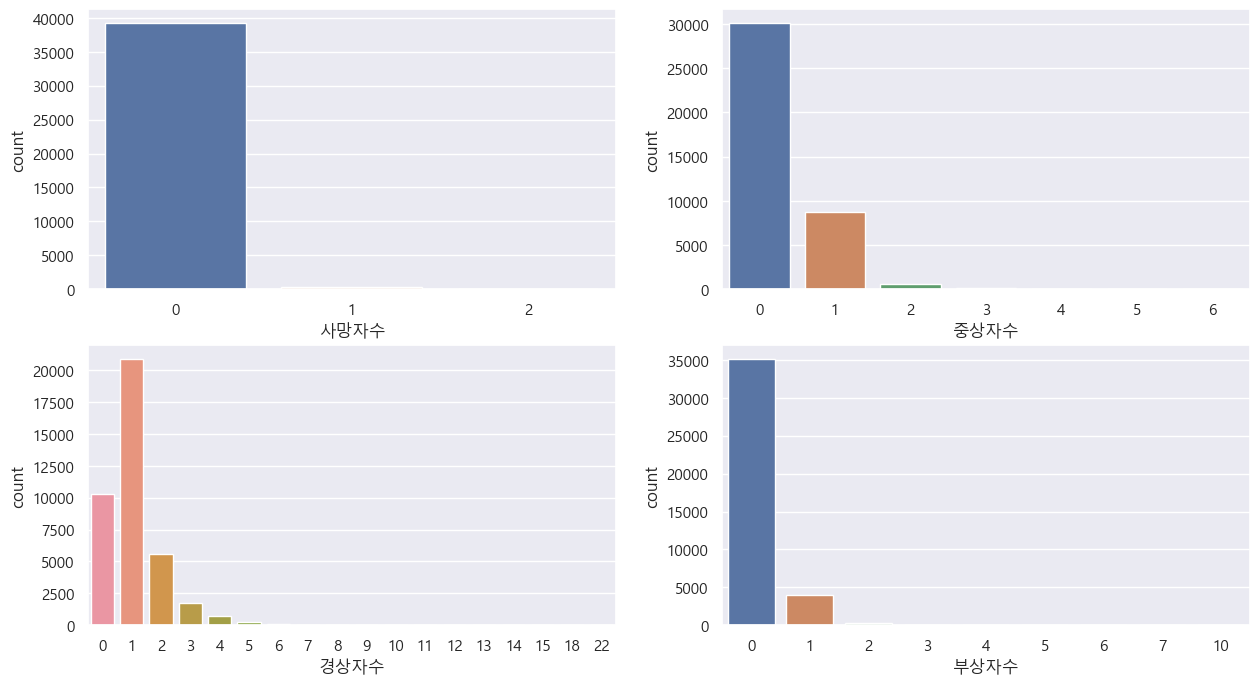

In [166]:
fig, ax = plt.subplots( nrows = 2, ncols=2)

sns.countplot(train_new["사망자수"], ax = ax[0, 0])
sns.countplot(train_new["중상자수"], ax = ax[0, 1])
sns.countplot(train_new["경상자수"], ax = ax[1, 0])
sns.countplot(train_new["부상자수"], ax = ax[1, 1])

<AxesSubplot:xlabel='ECLO', ylabel='Density'>

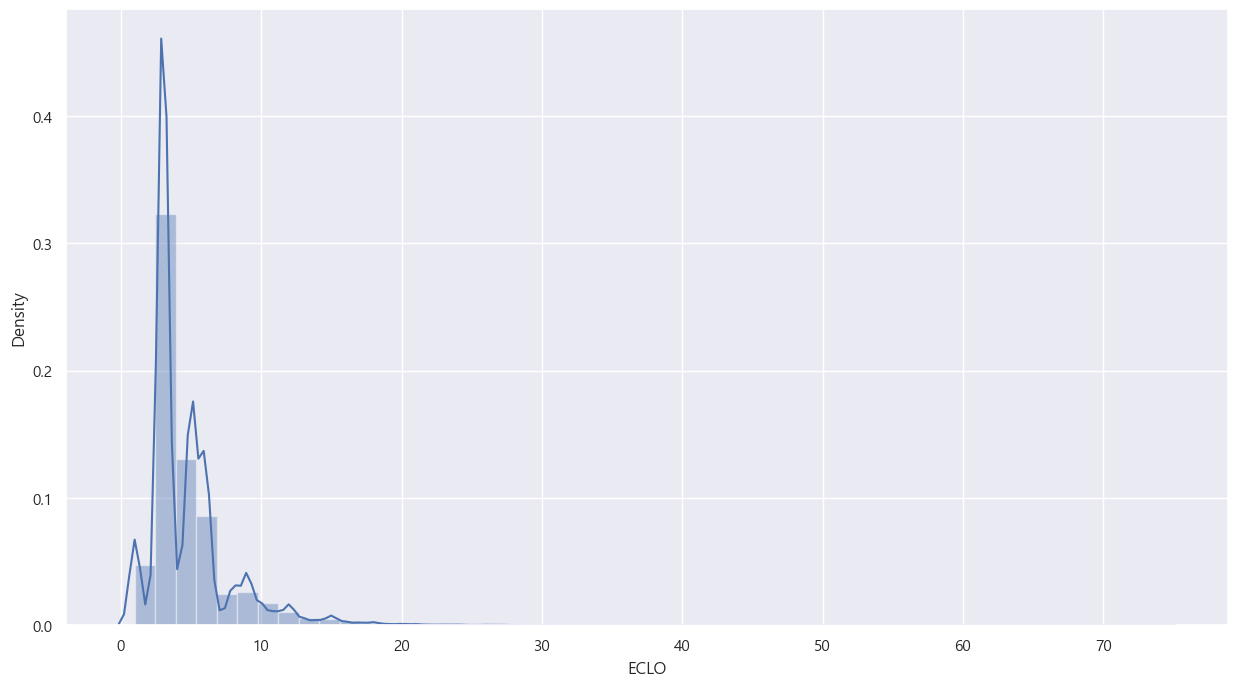

In [175]:
sns.distplot(train_new.ECLO)

In [185]:
sorted(list(set(train_new.요일)))

['금요일', '목요일', '수요일', '월요일', '일요일', '토요일', '화요일']

<AxesSubplot:xlabel='요일', ylabel='부상자수'>

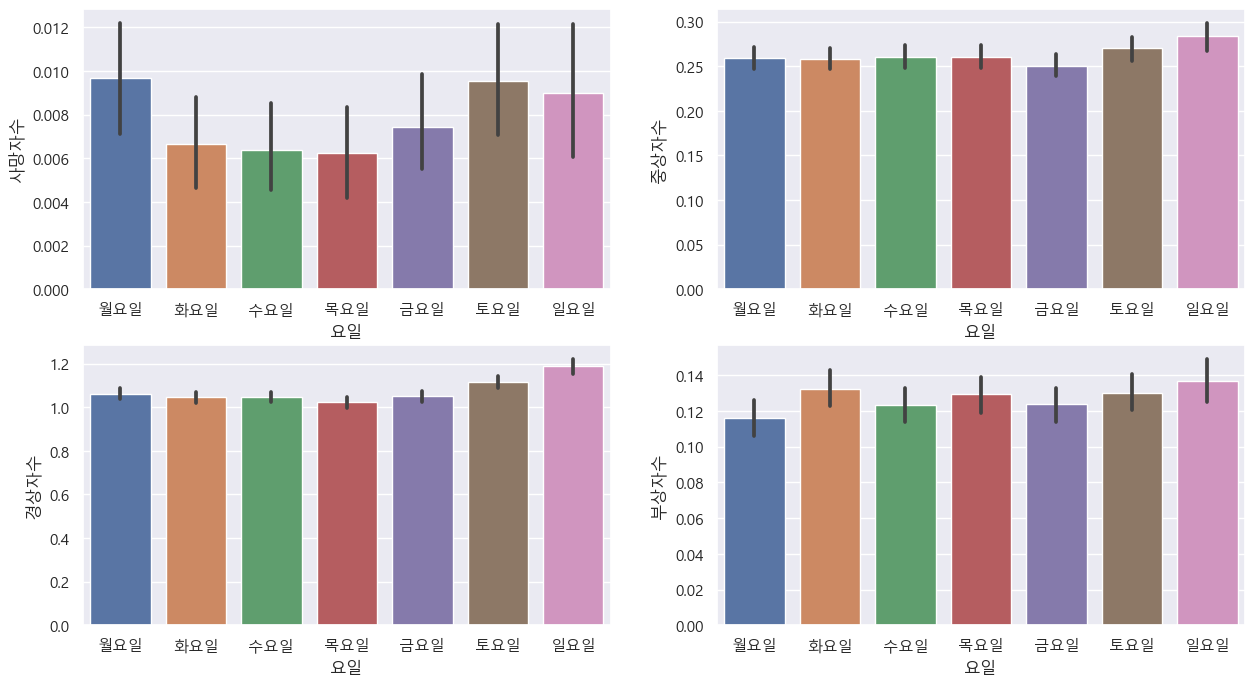

In [192]:

fig, ax = plt.subplots( nrows = 2, ncols=2)

sns.barplot(x = "요일", y = "사망자수", data = train_new, ax = ax[0, 0], order = ["월요일", "화요일", "수요일", "목요일", "금요일","토요일","일요일"])
sns.barplot(x = "요일", y = "중상자수", data = train_new, ax = ax[0, 1], order = ["월요일", "화요일", "수요일", "목요일", "금요일","토요일","일요일"])
sns.barplot(x = "요일", y = "경상자수", data = train_new, ax = ax[1, 0], order = ["월요일", "화요일", "수요일", "목요일", "금요일","토요일","일요일"])
sns.barplot(x = "요일", y = "부상자수", data = train_new, ax = ax[1, 1], order = ["월요일", "화요일", "수요일", "목요일", "금요일","토요일","일요일"])

In [ ]:
# 쉬는 날 변수 생성해서 쉬는 날과 그렇지 않은 날 비교


In [176]:
train_new.columns


Index(['요일', '기상상태', '노면상태', '사고유형', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO',
       'Hour', 'Year', 'Month', 'Day', 'Year_Month', '군', '구', '도로형태대분류',
       '도로형태소분류', '어린이보호구역', '노인보호구역', '기타보호구역', '속도단속', '신호단속', '통행위반',
       '불법주정차', '기타단속', '총CCTV개수', '보안등개수', 'CCTV설치여부'],
      dtype='object')

In [124]:
# 범주형 변수 전부 라벨링
train_new_t = train_new.copy()
for column in ['요일', '기상상태', '노면상태', '사고유형', 'Hour', 'Year', 'Month', 'Day',
       'Year_Month', '군', '구', '도로형태대분류', '도로형태소분류']:
    le = LabelEncoder()
    le.fit(train_new_t[column])
    train_new_t[column] = le.transform(train_new_t[column])


<AxesSubplot:>

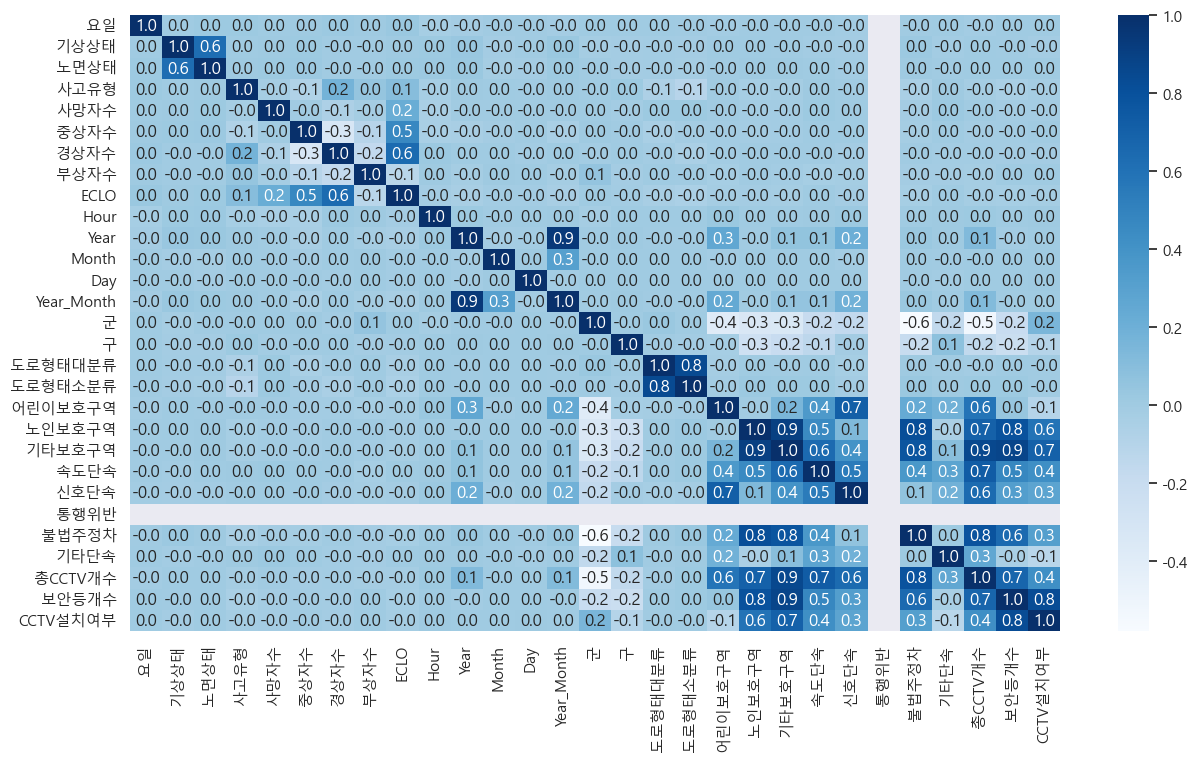

In [127]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
sns.heatmap(train_new_t.corr(), annot = True, fmt = ".1f", cmap="Blues")

In [62]:
train_new

,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,...,사망자수,중상자수,경상자수,부상자수,ECLO,Hour,Year,Month,Day,Total
0,6,2,155,6,0,0,2,7,5,2,...,0,1,0,0,5,0,0,0,0,1
1,6,5,4,6,0,0,5,2,5,1,...,0,0,1,0,3,0,0,0,0,1
2,6,2,124,6,0,0,9,7,5,1,...,0,0,1,0,3,1,0,0,0,1
3,6,2,98,6,0,1,10,7,5,1,...,0,1,0,0,5,2,0,0,0,1
4,6,2,65,6,0,1,10,7,5,1,...,0,0,1,0,3,4,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,135,1,0,1,11,5,5,2,...,0,0,1,0,3,19,2,11,30,1
39605,0,2,11,6,0,1,11,6,5,2,...,0,0,1,0,3,19,2,11,30,1
39606,0,2,16,1,0,1,11,1,5,1,...,0,2,0,0,10,21,2,11,30,2
39607,0,2,21,3,0,1,10,7,5,1,...,0,0,1,0,3,22,2,11,30,1


<Axes: xlabel='Year'>

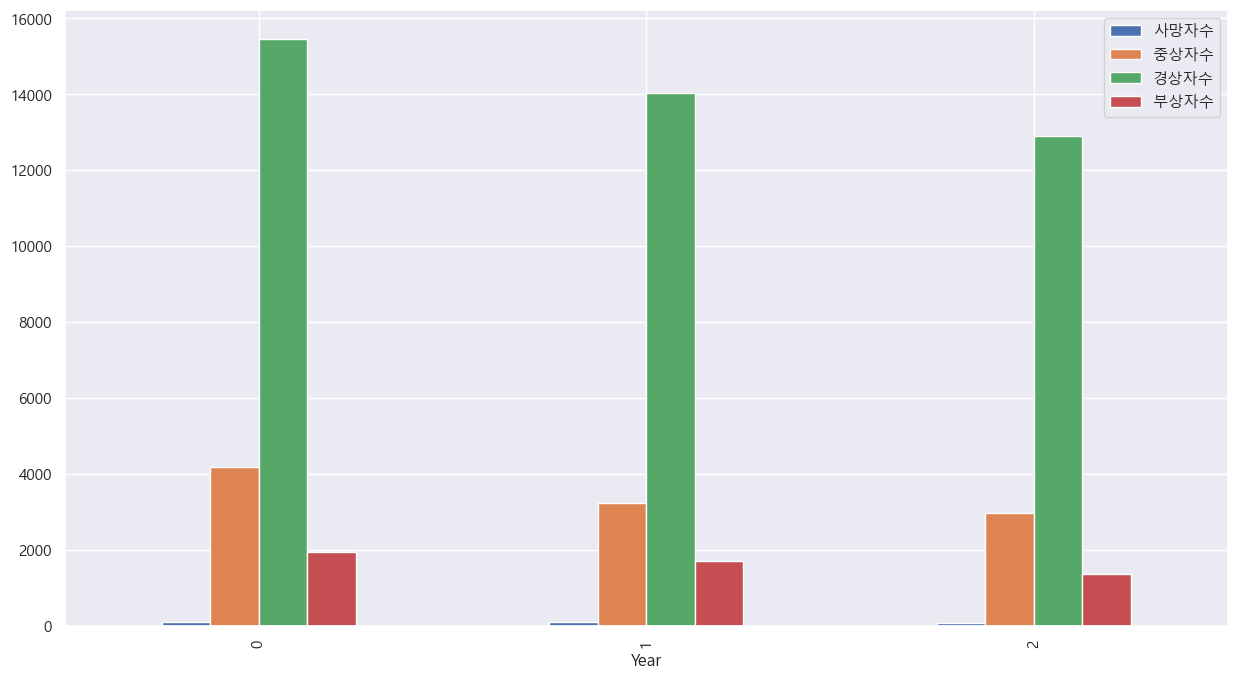

In [68]:
# 한글 깨짐
plt.rcParams['font.family'] = 'Malgun Gothic'

# Year 기준 전체적으로 줄어가는 추세
# Month, Day, 요일은 큰 의미없음
train_new.groupby("Year").sum()[["사망자수","중상자수","경상자수","부상자수"]].plot(kind = "bar")

<Axes: xlabel='기상상태'>

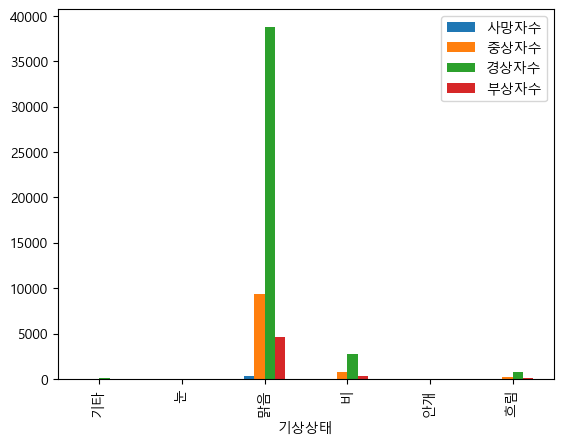

In [37]:
# 맑은 날이 많아서인지 맑은 날 가장 사고가 많음
train_new.groupby("기상상태").sum()[["사망자수","중상자수","경상자수","부상자수"]].plot(kind = "bar")

In [38]:
# 단일로 - 기타, 교차로-교차로안이 유독 많음
train_new.groupby(["도로형태"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
도로형태,,,,,
교차로 - 교차로부근,28,1376,6670,773,27943
교차로 - 교차로안,66,2933,11036,1283,49716
교차로 - 교차로횡단보도내,18,585,945,137,6077
기타 - 기타,9,444,1850,215,8075
단일로 - 고가도로위,2,24,207,14,775
단일로 - 교량,3,48,305,24,1209
단일로 - 기타,178,4849,20719,2501,90683
단일로 - 지하차도(도로)내,1,81,320,39,1414
단일로 - 터널,3,16,102,5,421


In [39]:
# 건조할 경우 전체 사고가 많음
train_new.groupby(["노면상태"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
노면상태,,,,,
건조,268,9454,39023,4624,171643
기타,2,20,37,6,237
서리/결빙,0,6,22,8,104
적설,0,0,3,0,9
젖음/습기,37,912,3298,386,15210
침수,1,0,2,1,17


In [20]:

train.groupby(["사고유형 - 세부분류"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
사고유형 - 세부분류,,,,,
공작물충돌,27,121,175,94,1494
기타,79,2724,9672,1503,44929
길가장자리구역통행중,0,100,300,72,1472
도로외이탈 - 기타,0,0,2,2,8
도로외이탈 - 추락,3,3,3,0,54
보도통행중,5,192,311,41,1984
전도전복 - 전도,5,45,56,57,500
전도전복 - 전복,1,7,4,2,59
정면충돌,17,329,908,98,4637


In [21]:
# 안전운전불이행이 사고를 가장 많이 일으킴
train.groupby(["법규위반"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
법규위반,,,,,
과속,22,88,140,15,1095
교차로운행방법위반,1,685,3339,352,13804
기타,19,439,1072,166,5767
보행자보호의무위반,8,517,644,48,4645
불법유턴,6,106,412,52,1878
신호위반,37,1582,3963,378,20547
안전거리미확보,7,963,7076,768,26881
안전운전불이행,191,5255,22354,2845,98092
중앙선침범,15,346,965,117,4892


In [22]:

train.groupby(["가해운전자 차종"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 차종,,,,,
개인형이동수단(PM),0,51,92,46,577
건설기계,6,134,498,21,2245
기타불명,0,114,579,367,2674
농기계,0,0,3,1,10
사륜오토바이(ATV),0,3,3,5,29
승용,165,6790,30998,2585,131179
승합,15,463,1366,166,6729
원동기,4,138,333,121,1850
이륜,47,1132,3432,1019,17445


In [23]:

train.groupby(["가해운전자 성별"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 성별,,,,,
기타불명,0,113,589,368,2700
남,263,7912,30955,3615,138670
여,45,2367,10841,1042,45850


<Axes: xlabel='가해운전자 연령'>

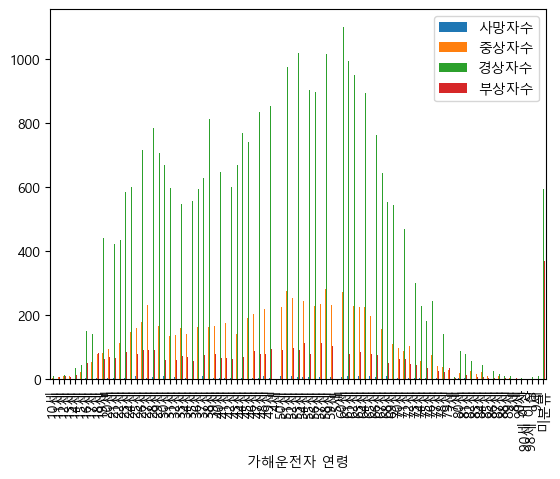

In [28]:
train.groupby(["가해운전자 연령"]).sum()[["사망자수","중상자수","경상자수","부상자수"]].plot(kind = "bar")

In [30]:
train.groupby(["가해운전자 상해정도"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 상해정도,,,,,
경상,10,594,7927,153,27004
기타불명,4,428,2334,483,9665
부상신고,3,255,1363,2661,8055
사망,95,18,36,0,1148
상해없음,176,7724,30113,1711,132430
중상,20,1373,612,17,8918


In [32]:
train.groupby(["가해운전자 차종","피해운전자 차종"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

사망자수  중상자수  경상자수  부상자수  ECLO
가해운전자 차종    피해운전자 차종                                 
개인형이동수단(PM) 개인형이동수단(PM)     0     3     2     1    22
            기타불명            0     0     0     1     1
            보행자             0    21    33     6   210
            승용              0    17    31    25   203
            승합              0     0     2     1     7
...                       ...   ...   ...   ...   ...
화물          원동기             0    23    38     7   236
            이륜              5   188   288    21  1875
            자전거             3    95   133     9   913
            특수              0     6    12     0    66
            화물             10    93   451    33  1951

[117 rows x 5 columns]

In [29]:
train.columns

Index(['요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',
       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',
       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',
       'ECLO', 'Hour', 'Year', 'Month', 'Day'],
      dtype='object')